In [2]:
import random
from typing import Union

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import transformers

# ######################## PART 1: PROVIDED CODE ########################

def load_datasets(data_directory: str) -> Union[dict, dict]:
    """
    Reads the training and validation splits from disk and load
    them into memory.

    Parameters
    ----------
    data_directory: str
        The directory where the data is stored.
    
    Returns
    -------
    train: dict
        The train dictionary with keys 'premise', 'hypothesis', 'label'.
    validation: dict
        The validation dictionary with keys 'premise', 'hypothesis', 'label'.
    """
    import json
    import os

    with open(os.path.join(data_directory, "train.json"), "r") as f:
        train = json.load(f)

    with open(os.path.join(data_directory, "validation.json"), "r") as f:
        valid = json.load(f)

    return train, valid


class NLIDataset(torch.utils.data.Dataset):
    def __init__(self, data_dict: dict):
        self.data_dict = data_dict
        dd = data_dict

        if len(dd["premise"]) != len(dd["hypothesis"]) or len(dd["premise"]) != len(
            dd["label"]
        ):
            raise AttributeError("Incorrect length in data_dict")

    def __len__(self):
        return len(self.data_dict["premise"])

    def __getitem__(self, idx):
        dd = self.data_dict
        return dd["premise"][idx], dd["hypothesis"][idx], dd["label"][idx]


def train_distilbert(model, loader, device):
    model.train()
    criterion = model.get_criterion()
    total_loss = 0.0
    train_accuracy = []
    for premise, hypothesis, target in tqdm(loader):
        optimizer.zero_grad()

        inputs = model.tokenize(premise, hypothesis).to(device)
        target = target.to(device, dtype=torch.float32)
        #print(inputs)
        pred = model(inputs)
        #print(pred)
        #print(target)
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    print("training accuracy is ")
    accuracy = torch.eq(target, pred.round())
    true_count = 0
    all_count = 0
    # Loop through each element
    for element in accuracy:
        all_count += 1
        if element:  # Check if element is True
             true_count += 1
    print(true_count/all_count)
    return total_loss / len(loader), true_count/all_count


@torch.no_grad()
def eval_distilbert(model, loader, device):
    model.eval()

    targets = []
    preds = []

    for premise, hypothesis, target in loader:
        preds.append(model(model.tokenize(premise, hypothesis).to(device)))

        targets.append(target)

    return torch.cat(preds), torch.cat(targets)

In [3]:
#A4 START HERE
class CustomDistilBert(nn.Module):
    def __init__(self):
        super().__init__()
        self.distilbert = transformers.DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.tokenizer = transformers.DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
        self.pred_layer = nn.Linear(self.distilbert.config.hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        self.criterion = nn.BCELoss()

    # vvvvv DO NOT CHANGE BELOW THIS LINE vvvvv
    def get_distilbert(self):
        return self.distilbert

    def get_tokenizer(self):
        return self.tokenizer

    def get_pred_layer(self):
        return self.pred_layer

    def get_sigmoid(self):
        return self.sigmoid
    
    def get_criterion(self):
        return self.criterion
    # ^^^^^ DO NOT CHANGE ABOVE THIS LINE ^^^^^

    def assign_optimizer(self, **kwargs):
        model_params = self.parameters()
        optimizer = torch.optim.Adam(model_params, **kwargs)  
        return optimizer

    def slice_cls_hidden_state(
        self, x: transformers.modeling_outputs.BaseModelOutput
    ) -> torch.Tensor:
        last_states = x.last_hidden_state
        result =last_states[:, 0, :]
        return result

    def tokenize(
        self,
        premise: "list[str]",
        hypothesis: "list[str]",
        max_length: int = 128,
        truncation: bool = True,
        padding: bool = True,
    ):
        tokenizer = self.get_tokenizer()
        encoded_inputs = tokenizer(premise, hypothesis,
                              max_length=max_length,
                              truncation=truncation,
                              padding=padding,
                              return_tensors="pt")
        return encoded_inputs

    def forward(self, inputs: transformers.BatchEncoding):
        #print(inputs)
        outputs = self.distilbert(**inputs)
        cls_token_hidden_state = self.slice_cls_hidden_state(outputs)
        zero_one = self.pred_layer(cls_token_hidden_state)
        #print(zero_one)
        predictions = self.sigmoid(zero_one)
        return predictions[:, 0]

In [4]:
import pandas as pd
from sklearn.metrics import f1_score  # Make sure sklearn is installed
import random
random.seed(2022)
torch.manual_seed(2022)

# Parameters (you can change them)
sample_size = 2500  # Change this if you want to take a subset of data for testing
batch_size = 64
n_epochs = 10
num_words = 50000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_raw, valid_raw = load_datasets("/kaggle/input/nli-dataset")
if sample_size is not None:
        for key in ["premise", "hypothesis", "label"]:
            train_raw[key] = train_raw[key][:sample_size]
            valid_raw[key] = valid_raw[key][:sample_size]
            
full_text = (
        train_raw["premise"]
        + train_raw["hypothesis"]
        + valid_raw["premise"]
        + valid_raw["hypothesis"]
    )

print("=" * 80)
print("Running test code for part 1")
print("-" * 80)

train_loader = torch.utils.data.DataLoader(
        NLIDataset(train_raw), batch_size=batch_size, shuffle=True
    )
valid_loader = torch.utils.data.DataLoader(
        NLIDataset(valid_raw), batch_size=batch_size, shuffle=False
    )

model = CustomDistilBert().to(device)
#optimizer = model.assign_optimizer(lr=1e-4)
optimizer = model.assign_optimizer(lr=1e-4)
validation_accuracy = []
training_accuracy = []
for epoch in range(n_epochs):
        loss, train_acc = train_distilbert(model, train_loader, device=device)
        training_accuracy.append(train_acc)
        preds, targets = eval_distilbert(model, valid_loader, device=device)
        #print("validation accuracy is ")
        #accuracy = torch.mean(torch.eq(target, pred.round())).item()
        #print(accuracy)
        preds = preds.round()
        print("validation accuracy is ")
        accuracy = torch.eq(targets.cpu(), preds.cpu()).to(device)
        true_count = 0
        all_count = 0
        # Loop through each element
        for element in accuracy:
            all_count += 1
            if element:  # Check if element is True
                true_count += 1
        print(true_count/all_count)
        validation_accuracy.append(true_count/all_count)
        score = f1_score(targets.cpu(), preds.cpu())
        print("Epoch:", epoch)
        print("Training loss:", loss)
        print("Validation F1 score:", score)
        print()

Running test code for part 1
--------------------------------------------------------------------------------


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

  0%|          | 0/40 [00:00<?, ?it/s]

training accuracy is 
0.75
validation accuracy is 
0.8592
Epoch: 0
Training loss: 0.561559347808361
Validation F1 score: 0.8516020236087689



  0%|          | 0/40 [00:00<?, ?it/s]

training accuracy is 
1.0
validation accuracy is 
0.8668
Epoch: 1
Training loss: 0.2666244987398386
Validation F1 score: 0.858478538036549



  0%|          | 0/40 [00:00<?, ?it/s]

training accuracy is 
0.75
validation accuracy is 
0.8796
Epoch: 2
Training loss: 0.1447750275954604
Validation F1 score: 0.8822839264763395



  0%|          | 0/40 [00:00<?, ?it/s]

training accuracy is 
1.0
validation accuracy is 
0.8852
Epoch: 3
Training loss: 0.07195402823854238
Validation F1 score: 0.8860658991663359



  0%|          | 0/40 [00:00<?, ?it/s]

training accuracy is 
1.0
validation accuracy is 
0.8488
Epoch: 4
Training loss: 0.037118682215805165
Validation F1 score: 0.8602071005917159



  0%|          | 0/40 [00:00<?, ?it/s]

training accuracy is 
1.0
validation accuracy is 
0.8756
Epoch: 5
Training loss: 0.039278462796937676
Validation F1 score: 0.8710078805474906



  0%|          | 0/40 [00:00<?, ?it/s]

training accuracy is 
1.0
validation accuracy is 
0.886
Epoch: 6
Training loss: 0.028623947105370463
Validation F1 score: 0.8835308541070699



  0%|          | 0/40 [00:00<?, ?it/s]

training accuracy is 
1.0
validation accuracy is 
0.8788
Epoch: 7
Training loss: 0.026728366647148505
Validation F1 score: 0.875462392108508



  0%|          | 0/40 [00:00<?, ?it/s]

training accuracy is 
1.0
validation accuracy is 
0.8732
Epoch: 8
Training loss: 0.028023137152194975
Validation F1 score: 0.8761234857366158



  0%|          | 0/40 [00:00<?, ?it/s]

training accuracy is 
1.0
validation accuracy is 
0.8772
Epoch: 9
Training loss: 0.022557691184920257
Validation F1 score: 0.8801249511909411



In [6]:
print(training_accuracy)
print(validation_accuracy)

[0.75, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.8592, 0.8668, 0.8796, 0.8852, 0.8488, 0.8756, 0.886, 0.8788, 0.8732, 0.8772]


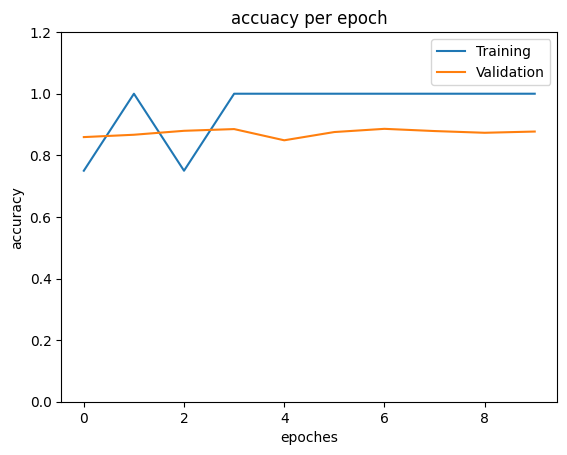

In [11]:
import matplotlib.pyplot as plt
x1 = range(10)
y1 = training_accuracy

y2 = validation_accuracy
x2 = range(10)

# Create the plot
plt.plot(x1, y1, label="Training")
plt.plot(x2, y2, label="Validation")

# Set labels for axes
plt.xlabel("epoches")
plt.ylabel("accuracy")

# Add a title (optional)
plt.title("accuacy per epoch")
plt.ylim(0, 1.2)
# Add a legend
plt.legend()

# Show the plot
plt.show()

In [21]:
#first_test
print(train_raw['premise'][0])
print(train_raw['hypothesis'][0])
print(train_raw['label'][0])
premise = train_raw['premise'][0]
hypothesis = train_raw['hypothesis'][0]

model.eval()
inputs = model.tokenize(premise, hypothesis).to(device)
pred = model(inputs)
pred.round().item()

A woman wearing a bike helmet and a warm-up suit is sitting in the park meditating.
A woman is sitting.
0


0.0

In [22]:
#second test
print(train_raw['premise'][1])
print(train_raw['hypothesis'][1])
print(train_raw['label'][1])
premise = train_raw['premise'][1]
hypothesis = train_raw['hypothesis'][1]

model.eval()
inputs = model.tokenize(premise, hypothesis).to(device)
pred = model(inputs)
pred.round().item()

A child in a tie dye shirt and one in a white shirt are on a climbing wall.
Two children climb a wall.
0


0.0

In [23]:
#third test
print(train_raw['premise'][2])
print(train_raw['hypothesis'][2])
print(train_raw['label'][2])
premise = train_raw['premise'][2]
hypothesis = train_raw['hypothesis'][2]

model.eval()
inputs = model.tokenize(premise, hypothesis).to(device)
pred = model(inputs)
pred.round().item()

Two brown dogs barking at each other.
The animals are making noise.
0


0.0